# Estimation of correlation between position angle offset and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the centroids (`"phi_light"`, `"phi_mass"`, `gamma_shear`, `phi_shear`, `q_mass`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate into the calculated position angle offsets. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the pearson correlation cofficient ($r$) between two parameters of interest. By sampling multiple times and calculating the $r$ we get a population of $r$ values and thus calculate the mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [30]:
import yaml
import numpy as np
from statistics import mean
from numpy.random import normal
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## List of the model names

In [31]:
lens_names = [
    "DESIJ1018-0121",
    "DESIJ1205+4110",
    "DESIJ1709+3154",
]

## Uncertainty propagation

In [32]:
num_lens = len(lens_names)

# list for storing the parameter values
q_mass_list = []
q_light_list = []
phi_mass_list = []
phi_light_list = []
gamma_shear_list = []
phi_shear_list = []

# list for storing the Sigmas
Sigma_10_dset = []
Sigma_10fs_dset = []
Sigma_20_dset = []
Sigma_20fs_dset = []

dphis = []
sigma_dphis = []

data_points = []

for i in range(num_lens):
    lens_name = lens_names[i]

    output_path = f"../lens_systems/{lens_name}/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue
    

    output = {
    'q_mass': data.get('q_mass'),
    'q_light': data.get('q_light'),
    'phi_mass': data.get('phi_mass'),
    'phi_light': data.get('phi_light'),
    'gamma_shear': data.get('gamma_shear'),
    'phi_shear': data.get('phi_sh'),
    'Sigma_10': data.get('Sigma_10'),
    'Sigma_10_flux_selected': data.get('Sigma_10_flux_selected'),
    'Sigma_20': data.get('Sigma_20'),
    'Sigma_20_flux_selected': data.get('Sigma_20_flux_selected')
    }

    data_points.append(output)

    Sigma_10_dset.append(data.get('Sigma_10'))
    Sigma_10fs_dset.append(data.get('Sigma_10_flux_selected'))
    Sigma_20_dset.append(data.get('Sigma_20'))
    Sigma_20fs_dset.append(data.get('Sigma_20_flux_selected'))


    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphis.append(dphi)

    sigma_phi_mass = mean([data_points[i]['phi_mass'][1], data_points[i]['phi_mass'][2]])
    sigma_phi_light = mean([data_points[i]['phi_light'][1], data_points[i]['phi_light'][2]])
    
    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2)**0.5
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]

## Sampling and pearson correlation coefficient ($r$) calculation

### Function definitions

In [35]:
# Function for sampling and calculating the pearson correlation coefficients 

def sample_dphi_and_calc_r(param2, size):
     """
     Sample and calculate pearson-r between the position angle offset and the param2, and return
     a list of the form [r_median, r_upper, r_lower].

     :param param2: a string; keyword for the parameter between which and 
      the position angle offset, pearson-r has to be calculated.
     :param size: population size of the pearson-r samples.
     :return: list; [r_median, r_upper, r_lower]
     """

     from numpy.random import normal
     from scipy.stats import pearsonr
     from statistics import mean
     
     
     samples_dphi = []
     p2 = []
     samples_r = []
    
     for i in range(size):
        for j in range(num_lens):
            samples_dphi.append(normal(dphis[j], sigma_dphis[j]))
            p2.append(data_points[j][param2])
        
        samples_r.append(pearsonr(samples_dphi, p2))
    
     samples_r_arr = np.array([x.statistic for x in samples_r])
     r_median = np.median(samples_r_arr).item()
     r_lower = np.percentile(samples_r_arr, 16.0).item()
     r_upper = np.percentile(samples_r_arr, 84.0).item()

     return [r_median, r_upper, r_lower]

In [36]:
# Function for sampling and calculating the pearson correlation coefficients 

def sample2_and_calc_r(param1, param2, size):
   """
   Sample and calculate pearson-r between param1 and the param2, and return
   a list of the form [r_median, r_lower, r_upper]

   :param param1: parameter for normal distribution sampling
   :param param2: parameter for normal distribution sampling
   :param size: population size of the pearson-r samples
   :return: list; [r_median, r_upper, r_lower]
   """

   from numpy.random import normal
   from scipy.stats import pearsonr
     
     
   p1 = []
   p2 = []
   samples_r = []
    
   for i in range(size):
      for j in range(num_lens):
         p1.append(normal(data_points[j][param1][0], 
                          (data_points[j][param1][1]+data_points[j][param1][2])*.5))
         p2.append(normal(data_points[j][param2][0], 
                          (data_points[j][param2][1]+data_points[j][param2][2])*.5))
      
      samples_r.append(pearsonr(p1, p2))
    
   samples_r_arr = np.array([x.statistic for x in samples_r])
   r_median = np.median(samples_r_arr).item()
   r_lower = np.percentile(samples_r_arr, 16.0).item()
   r_upper = np.percentile(samples_r_arr, 84.0).item()

   return [r_median, r_upper, r_lower]

### pearson-$r$ calculation

In [37]:
size = 100  # population size

In [38]:
# Calculate the pearson-r

r_dphi_gshear = sample2_and_calc_r("dphi", "gamma_shear", size)
r_dphi_qmass = sample2_and_calc_r("dphi", "q_mass", size)

print(r_dphi_gshear)
print(r_dphi_qmass)

[-0.06740385744514318, -0.0523363572621997, -0.07484529489851602]
[-0.8886786538087629, -0.874222138711645, -0.91502619753758]


## Scatter plot overlaid with error bar (position angle offset vs. $\Sigma$)

In [40]:
# Set the matplotlib typography

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'dejavusans'
plt.rcParams["font.size"] = 12

### Function definitions

In [41]:
# Function for scatter ploting of two sets of distributions with error bars

def scatter2_errbar_plot(param1, param2, r, ax):
    """
    Create scatter plot with error bars with respect to the centroid offset.
    """
    from statistics import mean
    
    
    ds1 = []
    ds1_err = []
    ds2 = []
    ds2_err = []

    for i in range(len(lens_names)):
        ds1.append(data_points[i][param1][0])
        ds1_err.append(mean([data_points[i][param1][1], data_points[i][param1][2]]))
        ds2.append(data_points[i][param1][0])
        ds2_err.append(mean([data_points[i][param2][1], data_points[i][param2][2]]))

    ax.scatter(ds1, ds2, c="r", s=100, alpha=0.3)
    ax.errorbar(ds1, ds2, 
             xerr=ds1_err, 
             yerr=ds2_err,
             fmt="o", color="r", alpha=0.3)
    
    match param1:
        case "gamma_shear":
            ax.set_xlabel(r"$\gamma_{shear}$")
        case "q_mass":
            ax.set_xlabel(r"$q_{mass}$")
            
    match param2:
        case "dphi":
            ax.set_ylabel(r'misalignment angle, $\Delta\phi$')

    ax.tick_params(direction='in')
    ax.text(0.8, 0.15, f'$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=ax.transAxes, fontsize=16, color='r')

## Plots

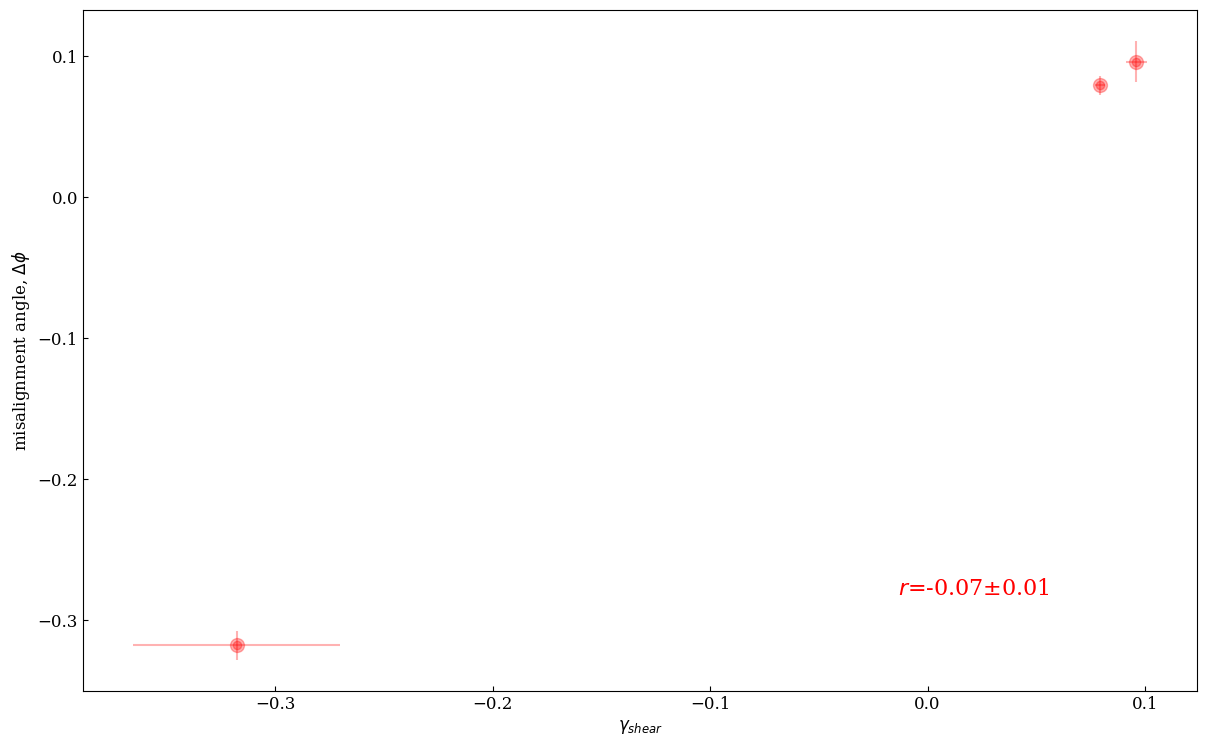

In [42]:
# plot for the case of position angle offset vs gamma_shear

fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))
fig.tight_layout()

scatter2_errbar_plot("gamma_shear", "dphi", r_dphi_gshear, ax)

plt.show()
fig.savefig("../paper/figures/dphi_vs_gamma_shear.pdf", bbox_inches="tight")


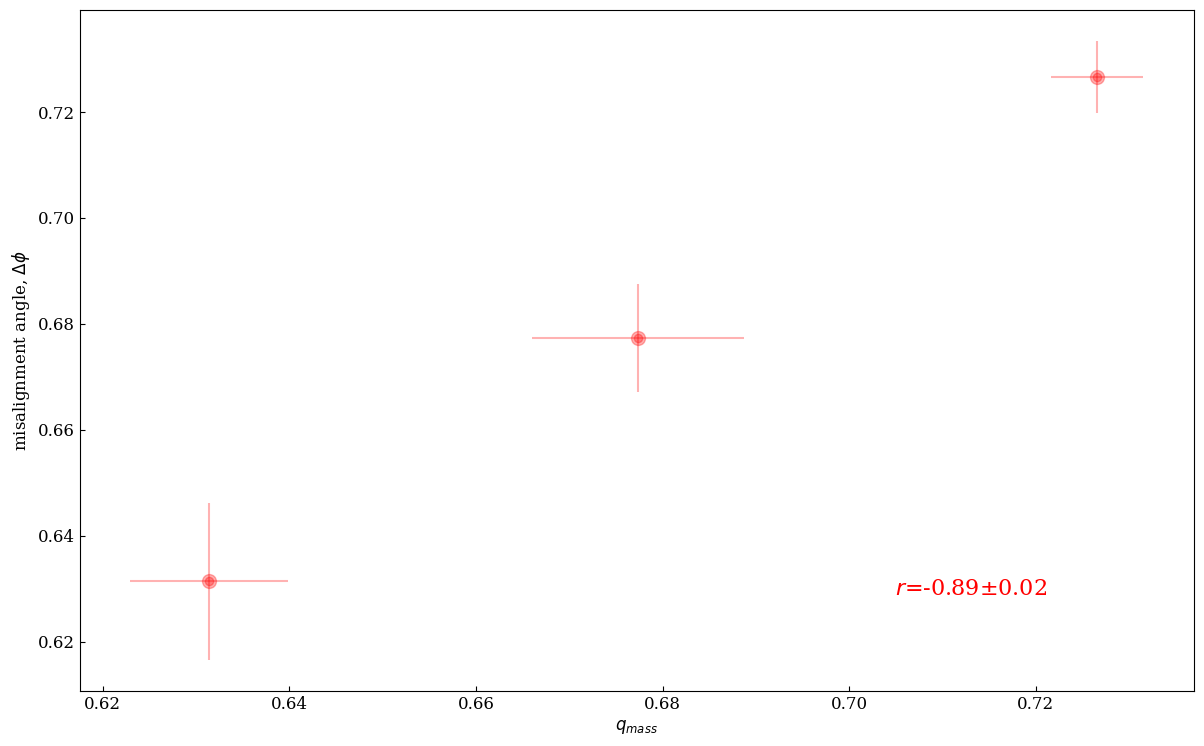

In [43]:

# plot for the case of position angle offset vs q_mass

fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))
fig.tight_layout()

scatter2_errbar_plot("q_mass", "dphi", r_dphi_qmass, ax)

plt.show()
fig.savefig("../paper/figures/dphi_vs_q_mass.pdf", bbox_inches="tight")


In [44]:
# calculate the pearson-r for the four cases of Sigma

r_dphi_Sigma_10 = sample_dphi_and_calc_r("Sigma_10", size)
r_dphi_Sigma_10fs = sample_dphi_and_calc_r("Sigma_10_flux_selected", size)
r_dphi_Sigma_20 = sample_dphi_and_calc_r("Sigma_20", size)
r_dphi_Sigma_20fs = sample_dphi_and_calc_r("Sigma_20_flux_selected", size)

print(r_dphi_Sigma_10)
print(r_dphi_Sigma_10fs)
print(r_dphi_Sigma_20)
print(r_dphi_Sigma_20fs)

[-0.5308617483770164, -0.5177338166543558, -0.5420741741607243]
[0.680197330486124, 0.6893074117082383, 0.6373411907566551]
[0.21254922249682956, 0.22328018188275556, 0.19801389519714327]
[0.838953516136699, 0.877769751500592, 0.8296987950957597]


In [45]:
# Function for scatter ploting with error bars

def scatter_errbar_plot(dset, param, r, ax0):
    """
    Create scatter plot with error bars with respect to the centroid offset.
    """
    ax0.scatter(dset, dphis, c="r", s=100, alpha=0.3)
    ax0.errorbar(dset, dphis, 
             yerr=sigma_dphis, 
             fmt='o', color='r', alpha=0.3)
    
    match param:
        case 'S_10':
            ax0.set_xlabel(r'$\Sigma_{10}$')
        case 'S_10fs':
            ax0.set_xlabel(r'$\Sigma_{10, \rm flux\ selected}$')
        case 'S_20':
            ax0.set_xlabel(r'$\Sigma_{20}$')
        case 'S_20fs':
            ax0.set_xlabel(r'$\Sigma_{20, \rm flux\ selected}$')
    
    ax0.set_ylabel(r'position angle offset, $\Delta\phi$')

    ax0.tick_params(direction='in')
    ax0.text(0.8, 0.15, f'$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=ax0.transAxes, fontsize=16, color='r')

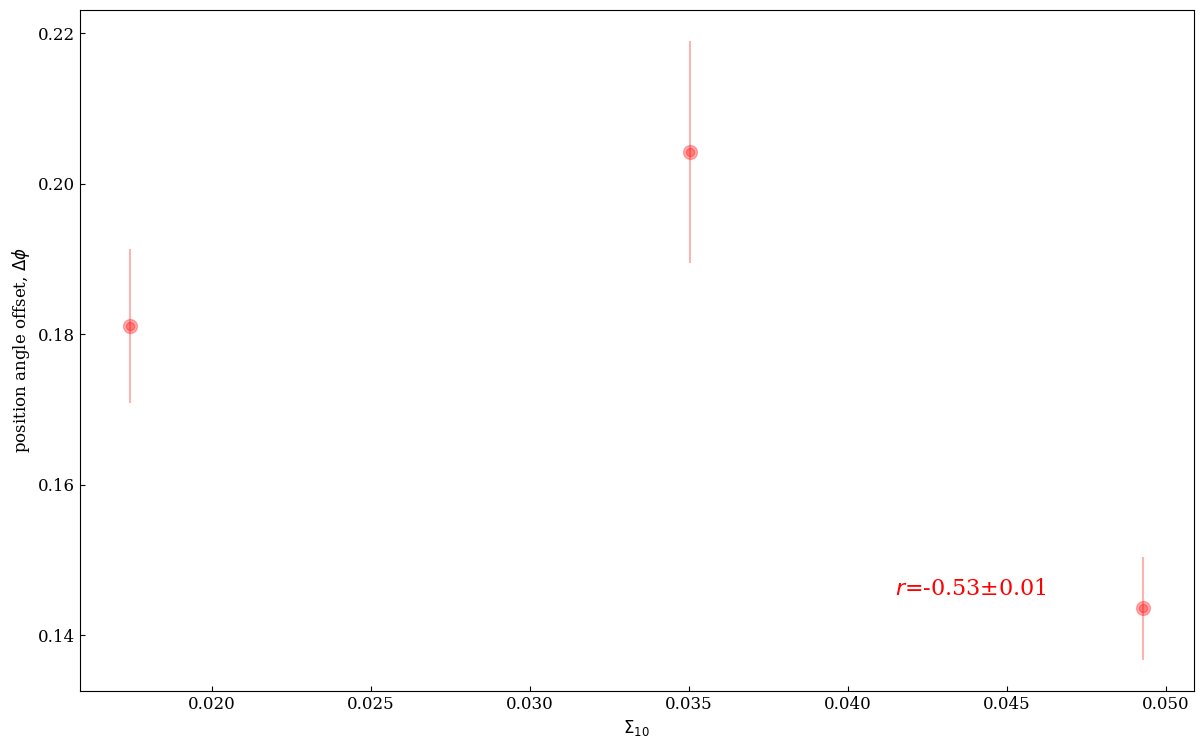

In [46]:
# plot for the case of position angle offset vs. Sigma_10

fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))
fig.tight_layout()


scatter_errbar_plot(Sigma_10_dset, 'S_10', r_dphi_Sigma_10, ax)

plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_10.pdf", bbox_inches="tight")


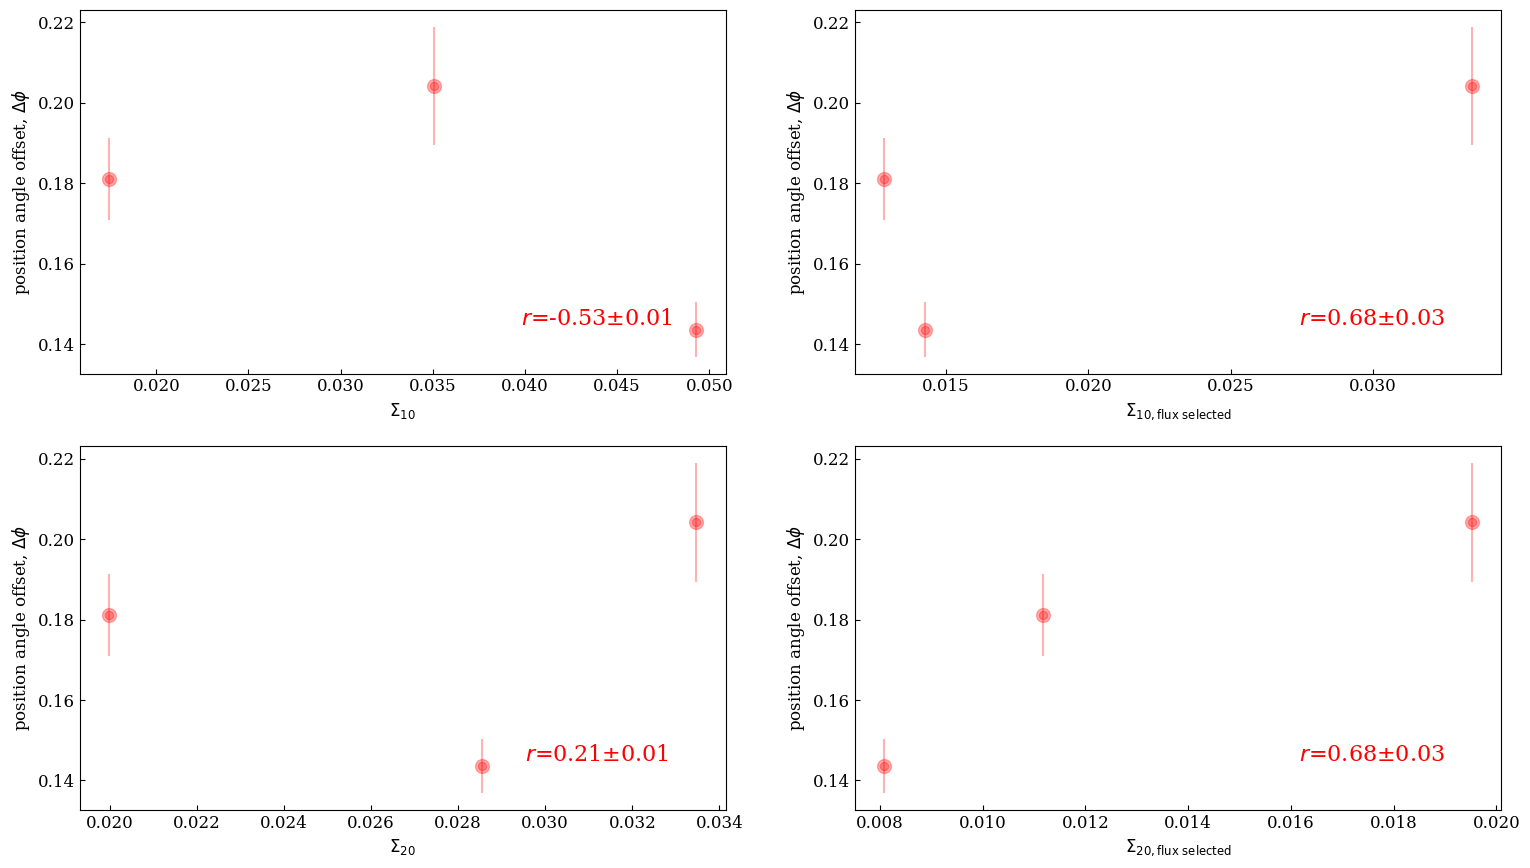

In [47]:

# plot for all the four cases of position angle offset vs. Sigmas

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(17.77, 10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


scatter_errbar_plot(Sigma_10_dset, 'S_10', r_dphi_Sigma_10, ax1)
scatter_errbar_plot(Sigma_10fs_dset, 'S_10fs', r_dphi_Sigma_10fs, ax2)
scatter_errbar_plot(Sigma_20_dset, 'S_20', r_dphi_Sigma_20, ax3)
scatter_errbar_plot(Sigma_20fs_dset, 'S_20fs', r_dphi_Sigma_10fs, ax4)

plt.show()
fig.savefig("../paper/figures/position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight")